<a href="https://colab.research.google.com/github/SSAC-AI/AI/blob/main/0708.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================
# 3 초보자를 위한 신호등 인식 코드 상세 설명
# ============================================

# 1. 필요한 라이브러리들 가져오기
import cv2          # 컴퓨터 비전 라이브러리 (이미지 처리용)
import numpy as np  # 숫자 계산용 라이브러리
import matplotlib.pyplot as plt  # 그래프/이미지 표시용
from google.colab import files   # 코랩에서 파일 업로드용
from PIL import Image           # 이미지 파일 읽기용
import io                      # 파일 입출력용

# ============================================
# 메인 함수 1: 신호등 찾는 함수 (색상 필터링 + Canny)
# ============================================
def detect_traffic_light_canny(image, min_area=100, max_area=8000, canny_low=50, canny_high=150, circularity_threshold=0.5, use_color_filter=True):
    """
    이 함수는 사진에서 신호등을 찾는 함수입니다 (색상 필터링 + Canny)
    입력: 컬러 사진, 최소면적, 최대면적, Canny 임계값들, 원형성 기준, 색상필터 사용여부
    출력: 신호등 위치들, 엣지 이미지
    """

    # 🔴 NEW Step: 색상 필터링 (신호등 색상만 찾기)
    if use_color_filter:
        print("Step 0: 신호등 색상 필터링 시작...")

        # HSV 색공간으로 변환 (색상 검출에 더 좋음)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # 빨강색 범위 (신호등 빨간불)
        red_lower1 = np.array([0, 70, 50])
        red_upper1 = np.array([10, 255, 255])
        red_lower2 = np.array([170, 70, 50])
        red_upper2 = np.array([180, 255, 255])
        red_lower3 = np.array([10, 70, 50])
        red_upper3 = np.array([20, 255, 255])

        # 노랑색 범위 (신호등 노란불)
        yellow_lower = np.array([20, 80, 80])   # Hue: 20부터 (노랑의 시작점), 채도/명도는 낮게
        yellow_upper = np.array([35, 255, 255]) # Hue: 35까지 (노랑~연노랑 경계)
        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        # 초록색 범위 (신호등 초록불)
        green_lower = np.array([35, 50, 50])
        green_upper = np.array([85, 255, 255])
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        # 파란색/청록색 범위 (보행자 신호등 파란불) 🆕 추가!
        blue_lower = np.array([75, 40, 40])
        blue_upper = np.array([105, 255, 255])
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)
        # 각 색상 마스크 생성
        red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
        red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(red_mask1, red_mask2)

        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)  # 🆕 파란색 마스크 추가!
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(cv2.bitwise_or(red_mask1, red_mask2), red_mask3)

        # 모든 신호등 색상 마스크 합치기 (파란색 포함)
        traffic_light_mask = red_mask
       # traffic_light_mask = cv2.bitwise_or(red_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, green_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, blue_mask)  # 🆕 파란색도 추가!

        # 마스크를 원본 이미지에 적용
        color_filtered = cv2.bitwise_and(image, image, mask=traffic_light_mask)

        # 색상 필터링된 이미지를 흑백으로 변환
        gray = cv2.cvtColor(color_filtered, cv2.COLOR_BGR2GRAY)
        print("Step 0: 색상 필터링 완료 (빨강/노랑/초록/파랑 영역만 추출)")
    else:
        # 색상 필터링 없이 바로 흑백 변환
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Step 1: 컬러 → 흑백 변환 완료 (색상 필터링 없음)")

    # 🟡 Step 2: 이미지를 부드럽게 만들기 (노이즈 제거)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    print("Step 2: 노이즈 제거 완료")

    # 🟡 Step 3: Canny 엣지 검출 (파라미터 조정됨!)
    edges = cv2.Canny(blurred, canny_low, canny_high)  # 조정 가능한 값들
    print(f"Step 3: 엣지 검출 완료 (임계값: {canny_low}-{canny_high})")

    # 🟡 Step 4: 엣지들로 윤곽선(컨투어) 찾기
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 🟡 Step 5: 찾은 윤곽선들 중에서 신호등 같은 것만 골라내기
    traffic_lights = []
    image_height = image.shape[0]  # 이미지 높이 구하기

    for i, contour in enumerate(contours):

        # 📏 크기 체크: 조정된 면적 범위 사용
        area = cv2.contourArea(contour)
        if area < min_area:  # 조정 가능한 최소 면적
            continue
        if area > max_area:  # 조정 가능한 최대 면적
            continue

        # 📐 윤곽선을 둘러싸는 사각형 구하기
        x, y, w, h = cv2.boundingRect(contour)
       # 위치필터링 추가
        # 🆕 위치 필터링: 신호등은 보통 이미지 상단에 있음
        if y > image_height * 0.8:  # 이미지 하단 30%에 있으면 제외
            continue

        # 📏 가로세로 비율 체크: 신호등은 세로가 더 김
        aspect_ratio = float(w) / h
        if aspect_ratio > 0.7:
            continue

        # 🔵 원형성 체크: 조정된 기준 사용
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter * perimeter)

        if circularity > circularity_threshold:  # 조정 가능한 원형성 기준
            print(f"    ✅ 신호등 후보 발견! (면적: {area}, 비율: {aspect_ratio:.2f}, 원형성: {circularity:.2f}, 위치: y={y})")
            traffic_lights.append((x, y, w, h))
        else:
            print(f"    ❌ 원형이 아님 (원형성: {circularity:.2f}, 기준: {circularity_threshold})")

    print(f"최종 결과: {len(traffic_lights)}개의 신호등 발견!")
    return traffic_lights, edges

# ============================================
# 메인 함수 2: 결과를 그림으로 그리는 함수
# ============================================
def draw_detections(image, detections):
    result = image.copy()
    height, width = image.shape[:2]
    step = height // 10

    # 가로선 10개 및 y좌표 표시
    for i in range(1, 11):
        y = i * step
        cv2.line(result, (0, y), (width, y), (255, 0, 0), 1)
        cv2.putText(result, f'y={y}', (5, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

    # 초록 반투명 박스 그리기
    overlay = result.copy()
    alpha = 0.3
    cv2.rectangle(overlay, (0, 90), (width, 130), (0, 255, 0), -1)
    cv2.rectangle(overlay, (0, 260), (width, 420), (0, 255, 0), -1)
    cv2.addWeighted(overlay, alpha, result, 1 - alpha, 0, result)

    # 범위 내에 있는 신호등만 그리기
    for i, (x, y, w, h) in enumerate(detections):
        # 신호등 영역 y의 중간값 계산
        center_y = y + h // 2
        # 범위 조건
        if (90 <= center_y <= 130) or (260 <= center_y <= 420):
            cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(result, f'Traffic Light {i+1}', (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    return result


# ============================================
# 🆕 색상 필터링 비교 테스트 함수
# ============================================
def compare_with_without_color():
    """
    색상 필터링 있을 때 vs 없을 때 비교
    """
    print("🎨 색상 필터링 비교 테스트!")
    print("📁 신호등 사진을 선택하세요...")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # 이미지 로드
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 1. 색상 필터링 없이 검출
    print("\n🔍 테스트 1: 색상 필터링 없이")
    detections1, edges1 = detect_traffic_light_canny(
        image_cv,
        min_area=100, max_area=8000,
        canny_low=50, canny_high=150,
        circularity_threshold=0.3,
        use_color_filter=False  # 색상 필터링 사용 안함
    )

    # 2. 색상 필터링 사용해서 검출
    print("\n🔍 테스트 2: 색상 필터링 사용")
    detections2, edges2 = detect_traffic_light_canny(
        image_cv,
        min_area=100, max_area=8000,
        canny_low=50, canny_high=150,
        circularity_threshold=0.30,
        use_color_filter=True   # 색상 필터링 사용!
    )

    # 결과 이미지 생성
    result1 = draw_detections(image_cv, detections1)
    result2 = draw_detections(image_cv, detections2)

    # 비교 결과 표시
    plt.figure(figsize=(20, 10))

    # 첫 번째 줄: 색상 필터링 없는 경우
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title(f'원본 이미지\n{filename}')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(edges1, cmap='gray')
    plt.title('Canny만 사용\n(색상 필터링 없음)')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
    plt.title(f'결과: {len(detections1)}개 검출\n(색상 필터링 없음)')
    plt.axis('off')

    # 두 번째 줄: 색상 필터링 있는 경우
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title('원본 이미지')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(edges2, cmap='gray')
    plt.title('색상 필터링 + Canny\n(빨강/노랑/초록만)')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(cv2.cvtColor(result2, cv2.COLOR_BGR2RGB))
    plt.title(f'결과: {len(detections2)}개 검출\n(색상 필터링 적용)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 결과 비교
    print(f"\n📊 결과 비교:")
    print(f"   색상 필터링 없음: {len(detections1)}개 검출")
    print(f"   색상 필터링 적용: {len(detections2)}개 검출")

    if len(detections2) > 0 and len(detections2) <= len(detections1):
        print("   ✅ 색상 필터링이 더 정확한 결과를 보여줍니다!")
    elif len(detections2) > len(detections1):
        print("   📈 색상 필터링으로 더 많은 신호등을 찾았습니다!")
    else:
        print("   🤔 두 방법 모두 신호등을 찾지 못했습니다. 다른 사진을 시도해보세요.")
def adjust_parameters_and_test():
    """
    다양한 파라미터로 테스트해서 최적값 찾기
    """
    print("🔧 파라미터 조정 테스트 모드!")
    print("📁 신호등이 있는 이미지를 선택하세요...")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # 이미지 로드
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 다양한 파라미터 조합 테스트
    param_sets = [
        {"name": "기본값", "min_area": 100, "max_area": 5000, "canny_low": 50, "canny_high": 150, "circularity": 0.3},
        {"name": "더 민감하게", "min_area": 50, "max_area": 10000, "canny_low": 30, "canny_high": 120, "circularity": 0.2},
        {"name": "더 엄격하게", "min_area": 200, "max_area": 8000, "canny_low": 70, "canny_high": 200, "circularity": 0.4},
        {"name": "큰 신호등용", "min_area": 500, "max_area": 15000, "canny_low": 40, "canny_high": 160, "circularity": 0.25}
    ]

    plt.figure(figsize=(20, 15))

    for i, params in enumerate(param_sets):
        print(f"\n🧪 테스트 {i+1}: {params['name']}")

        # 신호등 검출
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=params["min_area"],
            max_area=params["max_area"],
            canny_low=params["canny_low"],
            canny_high=params["canny_high"],
            circularity_threshold=params["circularity"]
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시 (4행 3열 그리드)
        plt.subplot(4, 3, i*3 + 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'{params["name"]}\n원본 이미지')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 2)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Canny {params["canny_low"]}-{params["canny_high"]}')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'결과: {len(detections)}개\n면적:{params["min_area"]}-{params["max_area"]}')
        plt.axis('off')

        print(f"   📊 {params['name']}: {len(detections)}개 검출")

    plt.tight_layout()
    plt.show()

    print("\n📝 어떤 설정이 가장 좋았나요?")
    print("   가장 잘 나온 파라미터를 기본값으로 사용하세요!")

# ============================================
# 기본 함수 (파라미터 자동 조정)
# ============================================
def upload_and_detect():
    """
    개선된 파라미터로 신호등 검출
    """
    print("🚀 신호등 인식 프로그램 시작! (개선된 버전)")
    print("📁 이미지 파일을 선택해주세요...")

    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n🖼️  파일 처리 시작: {filename}")

        image_data = uploaded[filename]
        image = Image.open(io.BytesIO(image_data))
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        print(f"이미지 크기: {image_cv.shape[1]} x {image_cv.shape[0]} 픽셀")

        # 크기 조정 (더 큰 크기 유지)
        height, width = image_cv.shape[:2]
        if width > 1000:  # 기존 800에서 1200으로 증가
            ratio = 1000 / width
            new_width = 1000
            new_height = int(height * ratio)
            image_cv = cv2.resize(image_cv, (new_width, new_height))
            print(f"크기 조정: {new_width} x {new_height}")

        # 개선된 파라미터로 신호등 찾기
        print("\n🔍 신호등 검출 시작... (색상 필터링 + Canny)")
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=60,     # 최적화된 파라미터
            max_area=8000,
            canny_low=30,
            canny_high=150,
            circularity_threshold=0.15,
            use_color_filter=True      # 🆕 색상 필터링 사용!
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'원본 이미지\n{filename}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny 엣지 검출\n(개선된 파라미터)')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'신호등 검출 결과\n🚦 {len(detections)}개 발견!')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"\n📋 최종 결과:")
        print(f"   검출된 신호등 개수: {len(detections)}개")

        if len(detections) > 0:
            for i, (x, y, w, h) in enumerate(detections):
                print(f"   🚦 신호등 {i+1}: 위치=({x}, {y}), 크기=({w} x {h})")
        else:
            print("   😅 신호등을 찾지 못했습니다.")

# ============================================
# 여러 사진 테스트 (개선된 버전)
# ============================================
def upload_multiple_images():
    """
    여러 사진을 연속으로 업로드해서 테스트하는 함수 (개선된 파라미터)
    """
    print("🚀 여러 사진 연속 테스트 모드! (개선된 버전)")

    while True:
        print("\n" + "="*50)
        print("📁 새로운 이미지를 업로드하세요")

        try:
            uploaded = files.upload()

            if not uploaded:
                print("👋 업로드가 취소되었습니다.")
                break

            for filename in uploaded.keys():
                print(f"\n🖼️  파일 처리: {filename}")

                image_data = uploaded[filename]
                image = Image.open(io.BytesIO(image_data))
                image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

                # 크기 조정
                height, width = image_cv.shape[:2]
                if width > 1000:
                    ratio = 1000 / width
                    new_width = 1000
                    new_height = int(height * ratio)
                    image_cv = cv2.resize(image_cv, (new_width, new_height))
                    print(f"📏 크기 조정: {width}x{height} → {new_width}x{new_height}")

                # 색상 필터링 + Canny로 검출
                detections, edges = detect_traffic_light_canny(
                    image_cv,
                    min_area=80,
                    max_area=8000,
                    canny_low=40,
                    canny_high=120,
                    circularity_threshold=0.15,
                    use_color_filter=True  # 🆕 색상 필터링 사용!
                )

                result_image = draw_detections(image_cv, detections)

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
                plt.title(f'원본: {filename}')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(edges, cmap='gray')
                plt.title('Canny 엣지')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
                plt.title(f'검출 결과\n🚦 {len(detections)}개 발견')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                print(f"📋 결과: {len(detections)}개 신호등 검출")
                for i, (x, y, w, h) in enumerate(detections):
                    print(f"   🚦 신호등 {i+1}: ({x}, {y}) 크기 {w}x{h}")

            response = input("\n🔄 다른 사진도 테스트하시겠습니까? (y/n): ").lower()
            if response not in ['y', 'yes', '예', 'ㅇ']:
                print("👋 테스트를 종료합니다!")
                break

        except Exception as e:
            print(f"❌ 오류 발생: {e}")
            break

# ============================================
# 🎯 실행 옵션들
# ============================================
print("=" * 50)
print("🚦 개선된 신호등 인식 프로그램")
print("=" * 50)
print()
print("🎯 실행 옵션을 선택하세요:")
print()
print("1️⃣ upload_and_detect()          - 색상 필터링 + Canny")
print("2️⃣ upload_multiple_images()     - 여러 사진 연속 테스트")
print("3️⃣ adjust_parameters_and_test() - 파라미터 비교 테스트")
print("4️⃣ compare_with_without_color()  - 색상 필터링 효과 비교")
print()
print("🔧 주요 개선 사항:")
print("   - 🎨 색상 필터링 추가: 빨강/노랑/초록/파랑 신호등 색상만 검출")
print("   - 면적 범위: 100~8000 (최적화)")
print("   - Canny 임계값: 30-120")
print("   - 원형성 기준: 0.25")
print("   - 위치 필터링: 하단 30% 제외")
print("   - 종횡비: 0.8 이하")
print("   - 이미지 크기: 최대 1200px")
print()
print("💡 추천 순서:")
print("   1. compare_with_without_color() - 색상 필터링 효과 확인")
print("   2. upload_multiple_images() - 여러 사진으로 테스트")
print()

# 바로 실행하려면 아래 중 하나의 주석을 해제하세요
upload_and_detect()
#upload_multiple_images()
# adjust_parameters_and_test()

🚦 개선된 신호등 인식 프로그램
1️⃣ upload_and_detect() - 2개 신호등 모두 인식
2️⃣ compare_parameters() - 파라미터 비교

💡 추천: upload_and_detect() 를 실행하세요!
🚦 개선된 신호등 인식 시작!


Saving KakaoTalk_20250708_085906042.png to KakaoTalk_20250708_085906042 (102).png

처리중: KakaoTalk_20250708_085906042 (102).png
Step 0: 신호등 색상 필터링 시작...
Step 0: 색상 필터링 완료 (빨강/노랑/초록/파랑 영역만 추출)
Step 2: 노이즈 제거 완료
Step 3: 엣지 검출 완료 (30-180)
Step 4: 470개 윤곽선 발견
최종 결과: 10개 신호등 발견


/tmp/ipython-input-41-426825087.py:210: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-41-426825087.py:210: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-41-426825087.py:210: UserWarning: Glyph 50659 (\N{HANGUL SYLLABLE ES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-41-426825087.py:210: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-41-426825087.py:210: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-41-426825087.py:210: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-41-426825087.py:210: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu San

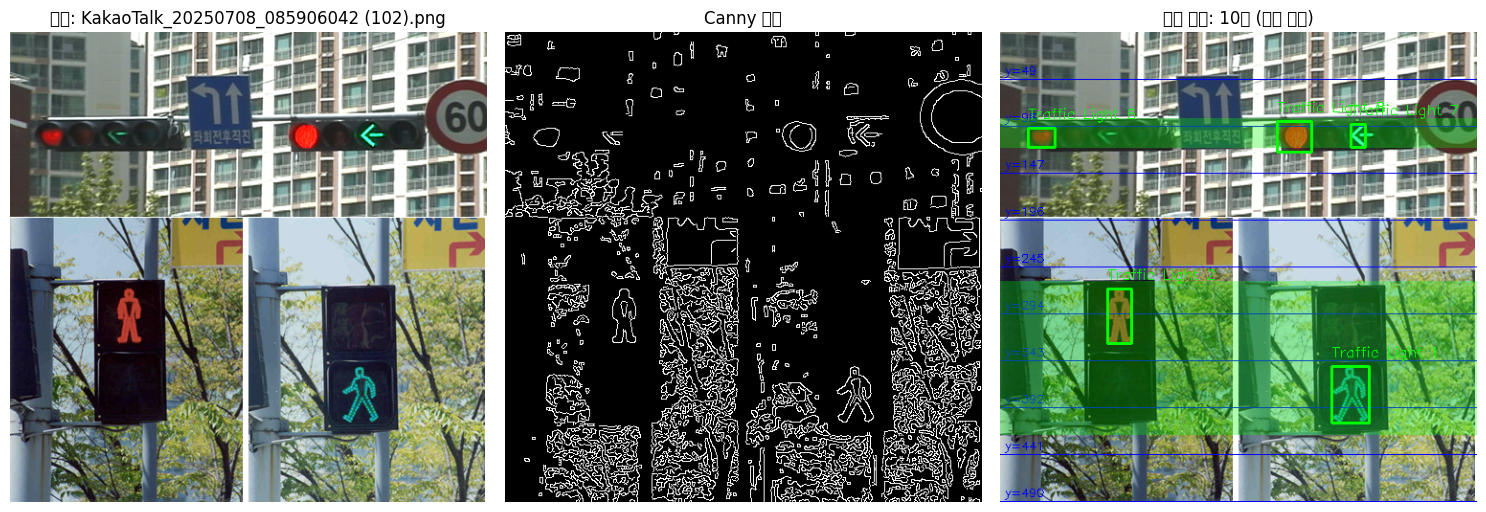

검출된 신호등 개수: 10개
  신호등 1: 위치=(346, 349), 크기=(39x59), 격자=78
  신호등 2: 위치=(112, 268), 크기=(25x57), 격자=63
  신호등 3: 위치=(410, 193), 크기=(86x55), 격자=50
  신호등 4: 위치=(154, 193), 크기=(90x65), 격자=44
  신호등 5: 위치=(45, 193), 크기=(51x20), 격자=42
  신호등 6: 위치=(29, 100), 크기=(28x20), 격자=21
  신호등 7: 위치=(366, 96), 크기=(15x24), 격자=28
  신호등 8: 위치=(289, 93), 크기=(36x32), 격자=27
  신호등 9: 위치=(354, 53), 크기=(15x13), 격자=18
  신호등 10: 위치=(53, 37), 크기=(25x15), 격자=2


In [ ]:
# ============================================
# 횡단보도 녹색+ 좌회전 녹색+ 빨강 횡단보도신호등 검출
# ============================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import io

def detect_traffic_light_canny(image, min_area=100, max_area=8000, canny_low=50, canny_high=150, circularity_threshold=0.5, use_color_filter=True):
    """
    이 함수는 사진에서 신호등을 찾는 함수입니다 (색상 필터링 + Canny)
    입력: 컬러 사진, 최소면적, 최대면적, Canny 임계값들, 원형성 기준, 색상필터 사용여부
    출력: 신호등 위치들, 엣지 이미지
    """

    # 🔴 NEW Step: 색상 필터링 (신호등 색상만 찾기)
    if use_color_filter:
        print("Step 0: 신호등 색상 필터링 시작...")

        # HSV 색공간으로 변환 (색상 검출에 더 좋음)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # 빨강색 범위 (신호등 빨간불)
        red_lower1 = np.array([0, 50, 50])
        red_upper1 = np.array([15, 255, 255])
        red_lower2 = np.array([170, 50, 50])
        red_upper2 = np.array([180, 255, 255])
        red_lower3 = np.array([10, 70, 50])
        red_upper3 = np.array([20, 255, 255])

        # 노랑색 범위 (신호등 노란불)
        yellow_lower = np.array([20, 80, 80])   # Hue: 20부터 (노랑의 시작점), 채도/명도는 낮게
        yellow_upper = np.array([35, 255, 255]) # Hue: 35까지 (노랑~연노랑 경계)
        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        # 초록색 범위 (신호등 초록불)
        green_lower = np.array([35, 50, 50])
        green_upper = np.array([90, 255, 255])
        green_mask1 = cv2.inRange(hsv, green_lower, green_upper)
        # 파란색/청록색 범위 (보행자 신호등 파란불) 🆕 추가!
        blue_lower = np.array([85, 50, 50])
        blue_upper = np.array([100, 255, 255])
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)
        # 각 색상 마스크 생성
        red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
        red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(red_mask1, red_mask2)

        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)  # 🆕 파란색 마스크 추가!
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(cv2.bitwise_or(red_mask1, red_mask2), red_mask3)

        # 모든 신호등 색상 마스크 합치기 (파란색 포함)
        traffic_light_mask = red_mask
       # traffic_light_mask = cv2.bitwise_or(red_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, green_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, blue_mask)  # 🆕 파란색도 추가!

        # 마스크를 원본 이미지에 적용
        color_filtered = cv2.bitwise_and(image, image, mask=traffic_light_mask)

        # 색상 필터링된 이미지를 흑백으로 변환
        gray = cv2.cvtColor(color_filtered, cv2.COLOR_BGR2GRAY)
        print("Step 0: 색상 필터링 완료 (빨강/노랑/초록/파랑 영역만 추출)")
    else:
        # 색상 필터링 없이 바로 흑백 변환
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Step 1: 컬러 → 흑백 변환 완료 (색상 필터링 없음)")


    # 가우시안 블러
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    print("Step 2: 노이즈 제거 완료")

    # Canny 엣지 검출
    edges = cv2.Canny(blurred, canny_low, canny_high)
    print(f"Step 3: 엣지 검출 완료 ({canny_low}-{canny_high})")

    # 컨투어 찾기
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Step 4: {len(contours)}개 윤곽선 발견")

    # 신호등 후보 필터링
    traffic_lights = []
    image_height = image.shape[0]

    for i, contour in enumerate(contours):
        # 면적 체크
        area = cv2.contourArea(contour)
        if area < min_area or area > max_area:
            continue

        # 위치 체크
        x, y, w, h = cv2.boundingRect(contour)
       # if y > image_height * 0.9:  # 하단10%는 제외 (더 관대하게)
        # 위치 체크 (상단 15% 제거, 하단 25% 제거)  추가 수정11시51분
        # 기존 코드의 이 부분을:
        if y < image_height * 0.15 or y > image_height * 0.75:

        # 이렇게 수정:
            center_y = y + h // 2
        if (center_y >= image_height * 0.45 and center_y <= image_height * 0.60):

        # 종횡비 체크
           aspect_ratio = float(w) / h
           if aspect_ratio > 0.9:  # 0.8에서 0.9로 더 관대하게
               continue

        # 원형성 체크
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter * perimeter)
        if circularity > circularity_threshold:
            traffic_lights.append((x, y, w, h))

    print(f"최종 결과: {len(traffic_lights)}개 신호등 발견")
    return traffic_lights, edges

def draw_detections(image, detections):
    result = image.copy()
    height, width = image.shape[:2]
    step = height // 10

    # 가로선 10개 및 y좌표 표시
    for i in range(1, 11):
        y = i * step
        cv2.line(result, (0, y), (width, y), (255, 0, 0), 1)
        cv2.putText(result, f'y={y}', (5, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

    # 초록 반투명 박스 그리기
    overlay = result.copy()
    alpha = 0.3
    cv2.rectangle(overlay, (0, 90), (width, 120), (0, 255, 0), -1)
    cv2.rectangle(overlay, (0, 260), (width, 420), (0, 255, 0), -1)
    cv2.addWeighted(overlay, alpha, result, 1 - alpha, 0, result)

    # 범위 내에 있는 신호등만 그리기
    for i, (x, y, w, h) in enumerate(detections):
        # 신호등 영역 y의 중간값 계산
        center_y = y + h // 2
        # 범위 조건
        if (90 <= center_y <= 120) or (260 <= center_y <= 420):
            cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(result, f'Traffic Light {i+1}', (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    return result

def upload_and_detect():
    """
    개선된 신호등 검출 (2개 모두 인식하도록 최적화)
    """
    print("🚦 개선된 신호등 인식 시작!")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n처리중: {filename}")

        # 이미지 로드
        image_data = uploaded[filename]
        image = Image.open(io.BytesIO(image_data))
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

        # 크기 조정
        height, width = image_cv.shape[:2]
        if width > 1200:
            ratio = 1200 / width
            image_cv = cv2.resize(image_cv, (1200, int(height * ratio)))

        # 신호등 검출 (최적화된 파라미터)
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=125,        # 50에서 80으로 (잡음 줄이기)
            max_area=8000,      # 충분한 범위
            canny_low=30,       # 민감한 엣지 검출
            canny_high=180,
            circularity_threshold=0.15,  # 0.2에서 0.15로 더 관대하게
            use_color_filter=True
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'원본: {filename}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny 엣지')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'검출 결과: {len(detections)}개 (격자 표시)')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"검출된 신호등 개수: {len(detections)}개")
        for i, (x, y, w, h) in enumerate(detections):
            # 격자 위치 계산
            center_x = x + w // 2
            center_y = y + h // 2
            height, width = image_cv.shape[:2]

            grid_col = int(center_x * 10 / width)
            grid_row = int(center_y * 10 / height)
            grid_number = grid_row * 10 + grid_col + 1

            print(f"  신호등 {i+1}: 위치=({x}, {y}), 크기=({w}x{h}), 격자={grid_number}")

def compare_parameters():
    """
    다양한 파라미터로 비교 테스트
    """
    print("🔧 파라미터 비교 테스트!")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 4가지 파라미터 세트 테스트 (수정: 4개로 맞춤)
    param_sets = [
        {"name": "관대한 설정", "min_area": 50, "max_area": 10000, "circularity": 0.1},
        {"name": "균형 설정", "min_area": 80, "max_area": 8000, "circularity": 0.15},
        {"name": "엄격한 설정1", "min_area": 100, "max_area": 6000, "circularity": 0.25},
        {"name": "엄격한 설정2", "min_area": 500, "max_area": 10000, "circularity": 0.25}
    ]

    plt.figure(figsize=(20, 15))  # 수정: 4x3 그리드에 맞게 크기 조정

    for i, params in enumerate(param_sets):
        print(f"\n테스트 {i+1}: {params['name']}")

        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=params["min_area"],
            max_area=params["max_area"],
            canny_low=30,
            canny_high=120,
            circularity_threshold=params["circularity"],
            use_color_filter=True
        )

        result = draw_detections(image_cv, detections, draw_grid=True)

        # 원본
        plt.subplot(4, 3, i*3 + 1)  # 수정: 4행으로 변경
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'{params["name"]}\n원본')
        plt.axis('off')

        # 엣지
        plt.subplot(4, 3, i*3 + 2)  # 수정: 4행으로 변경
        plt.imshow(edges, cmap='gray')
        plt.title('Canny 엣지')
        plt.axis('off')

        # 결과
        plt.subplot(4, 3, i*3 + 3)  # 수정: 4행으로 변경
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title(f'결과: {len(detections)}개')
        plt.axis('off')

        print(f"  {params['name']}: {len(detections)}개 검출")

    plt.tight_layout()
    plt.show()

# 실행 옵션
print("🚦 개선된 신호등 인식 프로그램")
print("1️⃣ upload_and_detect() - 2개 신호등 모두 인식")
print("2️⃣ compare_parameters() - 파라미터 비교")
print()
print("💡 추천: upload_and_detect() 를 실행하세요!")

# 바로 실행
upload_and_detect()